In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import io
import zipfile
from io import BytesIO
from zipfile import ZipFile
from sklearn.preprocessing import LabelEncoder, StandardScaler
import bisect

# 데이터 로드
# 특정 파일만 압축풀기
with ZipFile('../data/open.zip','r') as zipObj:
    list_filenames = zipObj.namelist()
    for filename in list_filenames:
        if filename.endswith('.csv'):
            zipRead = zipObj.read(filename)
            globals()[f'{filename[:-4]}'] = pd.read_csv(BytesIO(zipRead))
# train.csv >> train , test.csv >> test

# 날짜 데이터 전처리
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    # ARI_CO와 ARI_PO 컬럼 병합
    df['ARI'] = df['ARI_CO']+df['ARI_PO']

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

# 불필요 컬럼 제거 = 'ATA_LT','ID','SHIPMANAGER','FLAG'
train.drop(columns=['SAMPLE_ID','ATA_LT','ID','SHIPMANAGER','FLAG'], inplace=True)
test.drop(columns=['SAMPLE_ID','ATA_LT','ID','SHIPMANAGER','FLAG'], inplace=True)
# ARI_CO와 ARI_PO 컬럼 제거
train.drop(columns=['ARI_CO','ARI_PO'],axis=1,inplace=True)
test.drop(columns=['ARI_CO','ARI_PO'],axis=1,inplace=True)

# 같은 종류의 SHIP_TYPE으로 결측치 처리
Cargo_ships=train[train['SHIP_TYPE_CATEGORY']==train[train['BREADTH'].isnull()]['SHIP_TYPE_CATEGORY'].iloc[0]]
# 결측치 채우기
idx=train[train['BREADTH'].isnull()].index[0]
for df in [train,test]:
    for feature in ['BREADTH','DEADWEIGHT','DEPTH','DRAUGHT','LENGTH','GT']:
        df[feature] = df[feature].astype(float)
train.loc[idx,['BREADTH','DEADWEIGHT','DEPTH','DRAUGHT','LENGTH','GT']] = Cargo_ships[['BREADTH','DEADWEIGHT','DEPTH','DRAUGHT','LENGTH','GT']].mean().astype(float)

# ARI와 SHIP_TYPE_CATEGORY 인코딩
categorical_features = ['ARI','SHIP_TYPE_CATEGORY']
encoders = {}
for feature in categorical_features:
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [3]:
for key in encoders.keys():
    le = encoders.get(key)
    print(key,le.classes_)

ARI ['-1' 'AUAIB7' 'AUKSF1' 'AUNQO4' 'AUPBQ1' 'AUPDL4' 'AUQGL7' 'AUTBL3'
 'AUWHH4' 'AUWXQ2' 'AUYDP4' 'BRMMW5' 'BRTMW2' 'BRVFD8' 'BRXGX5' 'CABAZ5'
 'CAFFM2' 'CAGRQ5' 'CAPUF3' 'CATYY2' 'CAXIU1' 'CLGQJ7' 'CNBGX4' 'CNEKP8'
 'CNEUC8' 'CNFTQ1' 'CNJDG8' 'CNJEN5' 'CNJTD1' 'CNNCU8' 'CNNGG6' 'CNQQW1'
 'CNRGT8' 'CNSXD2' 'CNTDA5' 'CNTXO3' 'CNUVK6' 'CNWAF5' 'CNWEY7' 'CNXVZ3'
 'CNYRT6' 'FIDEJ2' 'IDDIN2' 'IDEVL6' 'IDPPM2' 'IDREJ1' 'IDURE2' 'IDXEO4'
 'INEIA2' 'INJER7' 'INOBZ3' 'INQTU5' 'INSLZ5' 'INUJM2' 'JPCSP6' 'JPHYG5'
 'JPIEW6' 'JPLXJ7' 'JPMIA8' 'JPMOC5' 'JPOOV8' 'JPQEA4' 'JPQYY1' 'JPSPG1'
 'JPTMR7' 'JPURD4' 'JPVYJ1' 'JPZAG4' 'KRBGD2' 'KRDMD4' 'KROKM4' 'KRRKA2'
 'LVMCG4' 'LVUEW5' 'MYEFG4' 'MYLHD1' 'MZOZD2' 'MZPAF4' 'PEHYV6' 'PEYFK5'
 'PHXZF6' 'QAKIU2' 'RUAZU6' 'RUFAV3' 'RUFCD5' 'RUHGH2' 'RUNNC2' 'RUQXE2'
 'RUUPI6' 'RUVXM8' 'RUZME5' 'SGGIW5' 'TTIVU2' 'TWEKP8' 'TWJWI3' 'UACEI5'
 'UAPEL6' 'USEVX2' 'USQGN3' 'USUIR7' 'VEJEA6' 'VNJGL5' 'VNONW1' 'VNQRN3'
 'ZACXL1']
SHIP_TYPE_CATEGORY ['-1' 'Bulk' 'Cargo' 

In [4]:
train = train.astype(np.float32)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391939 entries, 0 to 391938
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   SHIP_TYPE_CATEGORY  391939 non-null  float32
 1   DIST                391939 non-null  float32
 2   BREADTH             391939 non-null  float32
 3   BUILT               391939 non-null  float32
 4   DEADWEIGHT          391939 non-null  float32
 5   DEPTH               391939 non-null  float32
 6   DRAUGHT             391939 non-null  float32
 7   GT                  391939 non-null  float32
 8   LENGTH              391939 non-null  float32
 9   U_WIND              228251 non-null  float32
 10  V_WIND              228251 non-null  float32
 11  AIR_TEMPERATURE     227309 non-null  float32
 12  BN                  228251 non-null  float32
 13  PORT_SIZE           391939 non-null  float32
 14  CI_HOUR             391939 non-null  float32
 15  year                391939 non-nul

In [5]:
print(len(train[train['DIST']==0]))
train[(train['DIST']==0) & (train['CI_HOUR']!=0)]
#📢 DIST가 0이어도 대기시간이 존재하는 데이터가 있다

157293


,SHIP_TYPE_CATEGORY,DIST,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,U_WIND,V_WIND,AIR_TEMPERATURE,BN,PORT_SIZE,CI_HOUR,year,month,day,hour,ARI
2521,0.0,0.0,30.0,18.0,55600.0,20.0,10.0,31000.0,190.0,NaN,NaN,NaN,NaN,0.000103,280.732788,2017.0,9.0,17.0,16.0,50.0
6439,2.0,0.0,20.0,27.0,5220.0,10.0,10.0,4000.0,100.0,-3.82,-7.08,16.299999,4.524174,0.000399,0.748611,2021.0,10.0,1.0,10.0,83.0
24059,2.0,0.0,20.0,17.0,13800.0,10.0,10.0,9950.0,150.0,-0.33,-10.44,-10.400000,5.384442,0.000399,0.551389,2022.0,1.0,20.0,8.0,83.0
26501,2.0,0.0,30.0,7.0,23500.0,10.0,10.0,18800.0,170.0,-0.71,4.68,30.500000,3.176780,0.002615,0.049167,2020.0,7.0,2.0,7.0,90.0
36741,1.0,0.0,20.0,14.0,5200.0,10.0,10.0,2960.0,100.0,-5.65,-12.90,26.400000,6.571438,0.000068,10.000000,2020.0,10.0,8.0,13.0,102.0
39476,1.0,0.0,10.0,10.0,1270.0,0.0,0.0,670.0,70.0,-1.47,1.78,19.700001,1.968275,0.000356,634.015259,2022.0,3.0,30.0,16.0,66.0
59076,2.0,0.0,50.0,11.0,99800.0,20.0,10.0,90100.0,300.0,-2.14,-0.68,-4.000000,1.932250,0.000557,388.824432,2022.0,1.0,4.0,10.0,27.0
66864,2.0,0.0,20.0,27.0,5220.0,10.0,10.0,4000.0,100.0,0.93,-3.61,14.200000,2.709169,0.000399,1.748889,2021.0,10.0,1.0,14.0,83.0
69524,1.0,0.0,10.0,11.0,1600.0,10.0,0.0,500.0,60.0,4.78,-2.31,12.300000,3.429251,0.000069,21.300556,2022.0,2.0,14.0,6.0,63.0
73609,1.0,0.0,30.0,12.0,33500.0,10.0,10.0,21300.0,180.0,0.84,1.77,27.200001,1.764343,0.002615,191.500275,2021.0,5.0,10.0,1.0,90.0


In [6]:
train.isnull().sum()
# U_WIND, V_WIND, BN이 한 묶음
# AIR_TEMPERATURE 따로

SHIP_TYPE_CATEGORY         0
DIST                       0
BREADTH                    0
BUILT                      0
DEADWEIGHT                 0
DEPTH                      0
DRAUGHT                    0
GT                         0
LENGTH                     0
U_WIND                163688
V_WIND                163688
AIR_TEMPERATURE       164630
BN                    163688
PORT_SIZE                  0
CI_HOUR                    0
year                       0
month                      0
day                        0
hour                       0
ARI                        0
dtype: int64

---

In [4]:
# 바람 예측
air = train[['ARI','year','month','day','hour','AIR_TEMPERATURE']]

In [5]:
wind_bn = train[['ARI','year','month','day','hour','U_WIND','V_WIND','BN']].copy()
wind_bn_train = wind_bn[wind_bn['U_WIND'].notnull()]
wind_bn_test = wind_bn[wind_bn['U_WIND'].isnull()]
len(train)-len(wind_bn_train)

163688

In [2]:
# LSTM을 사용하여 결측값 예측
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np

In [3]:
# GPU 확인
print(torch.cuda.is_available())
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(torch.cuda.get_device_name())
print(torch.cuda.device_count())

True
NVIDIA GeForce RTX 3050 Ti Laptop GPU
1


In [8]:
# data
wind_bn = train[['ARI','year','month','day','hour','U_WIND','V_WIND','BN']].copy()
wind_bn_ = wind_bn[wind_bn['U_WIND'].notnull()]
wind_bn_for_pred = wind_bn[wind_bn['U_WIND'].isnull()]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(wind_bn_.loc[:,['ARI','year','month','day','hour']].values)

x = scaled_data
y = wind_bn_.loc[:,['U_WIND','V_WIND','BN']].values

x_train, x_val_test, y_train, y_val_test = train_test_split(x, y,
                                                test_size=0.4)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test,
                                                test_size=0.5)


In [9]:
# Convert the data into tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
x_val_tensor = torch.tensor(x_val, dtype=torch.float32).unsqueeze(1).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1).to(device)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).unsqueeze(1).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)

# x_train_tensor = torch.tensor(x_train, dtype=torch.float32).to(device)
# y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
# x_val_tensor = torch.tensor(x_val, dtype=torch.float32).to(device)
# y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)
# x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)
# y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

In [10]:
print(x_train_tensor.size())
print(y_train_tensor.size())
print(x_val_tensor.size())
print(y_val_tensor.size())
print(x_test_tensor.size())
print(y_test_tensor.size())

torch.Size([136950, 1, 5])
torch.Size([136950, 1, 3])
torch.Size([45650, 1, 5])
torch.Size([45650, 1, 3])
torch.Size([45651, 1, 5])
torch.Size([45651, 1, 3])


In [11]:
# Create data loaders
batch_size = 150

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [12]:
# Define the training parameters
input_size = x_train.shape[1]  # ARI, year, month, day, hour
hidden_size = 128
num_layers = 3
output_size = y_train.shape[1]  # U_WIND, V_WIND, BN
patience = 30

In [13]:
# Define the LSTM model
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, output_size):
    super(LSTM, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
    self.fc = nn.Linear(hidden_size, output_size)
  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
    out, _ = self.lstm(x, (h0, c0))
#     out, _ = self.lstm(x)
    out = self.fc(out[:, -1, :])
#     out = self.fc(out[:, -1])
    return out

In [14]:
# Create the LSTM model
wind_model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)

In [15]:
wind_model

LSTM(
  (lstm): LSTM(5, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)

In [17]:
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(wind_model.parameters(), lr=0.001)

In [19]:
# Train the model
best_loss = float('inf')
early_stopping_counter = 0
for epoch in range(1000):
    wind_model.train()
    train_loss = 0
    
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        output = wind_model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()

    average_train_loss = train_loss / len(train_loader.dataset)
        
    wind_model.eval()
    
    with torch.no_grad():
        for batch_x,batch_y in val_loader: ###📢여기 보던 중
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            output = wind_model(batch_x)
            loss = criterion(output, batch_y)
            val_loss += loss.item() * batch_x.size(0)
        
        average_val_loss = val_loss / len(val_loader.dataset)
        
        y_pred = wind_model(x_val_tensor)
        y_pred = y_pred.unsqueeze(0).repeat(y_val_tensor.shape[0], 1, 1)
        val_loss = criterion(y_pred, y_val_tensor)
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(wind_model.state_dict(), 'best_model.pth')
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                break

C:\Users\songkyu\anaconda3\envs\Python39_DA\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([150, 1, 3])) that is different to the input size (torch.Size([150, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


KeyboardInterrupt: 

In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the LSTM model
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, output_size):
    super(LSTM, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
    out, _ = self.lstm(x, (h0, c0))
    out = self.fc(out[:, -1, :])
    return out

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the training parameters
input_size = 5  # ARI, year, month, day, hour
hidden_size = 64
num_layers = 2
output_size = 3  # U_WIND, V_WIND, BN
batch_size = 150
patience = 30

# Prepare the data
data = train[['ARI', 'year', 'month', 'day', 'hour', 'U_WIND', 'V_WIND', 'BN']].copy()
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data.values)
x = scaled_data[:, :-3]
y = scaled_data[:, -3:]
x_train, x_val_test, y_train, y_val_test = train_test_split(x, y, test_size=0.4, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=0.5, random_state=42)

# Convert the data into tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
x_val_tensor = torch.tensor(x_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Create data loaders
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Create the LSTM model
model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Train the model
best_loss = float('inf')
early_stopping_counter = 0
for epoch in range(1000):
  model.train()
  for batch_x, batch_y in train_loader:
    optimizer.zero_grad()
    output = model(batch_x)
    loss = criterion(output, batch_y)
    loss.backward()
    optimizer.step()
  
  model.eval()
  with torch.no_grad():
    val_loss = criterion(model(x_val_tensor), y_val_tensor)
    if val_loss < best_loss:
      best_loss = val_loss
      torch.save(model.state_dict(), 'best_model.pth')
      early_stopping_counter = 0
    else:
      early_stopping_counter += 1
      if early_stopping_counter >= patience:
        break

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate the model on the test set
model.eval()
y_pred = model(x_test_tensor)
test_loss = criterion(y_pred, y_test_tensor)



RuntimeError: For unbatched 2-D input, hx and cx should also be 2-D but got (3-D, 3-D) tensors

(228251, 5) (228251, 3)


(164340, 5)

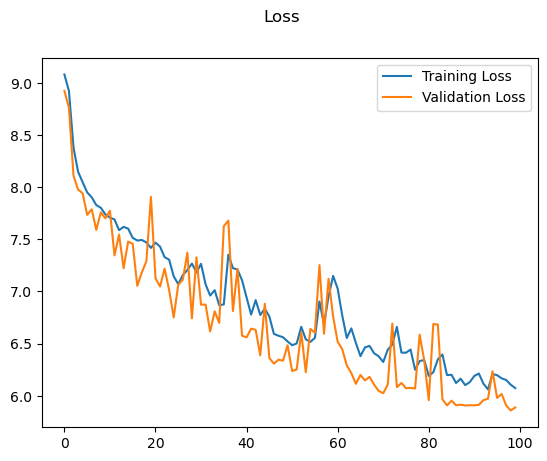

In [20]:
fig, ax = plt.subplots()
plt.plot(wind_training_record.history["loss"], label="Training Loss")
plt.plot(wind_training_record.history["val_loss"], label="Validation Loss")
plt.legend()
fig.suptitle("Loss")
plt.show()

In [26]:
# 기온 예측
air_train = air[air['AIR_TEMPERATURE'].notnull()]
len(train)-len(air_train)

164630

In [27]:
x_air_train = air_train.drop(columns=['AIR_TEMPERATURE'],axis=1)
y_air_train = air_train['AIR_TEMPERATURE']
print(x_air_train.shape,y_air_train.shape)

(227309, 5) (227309,)


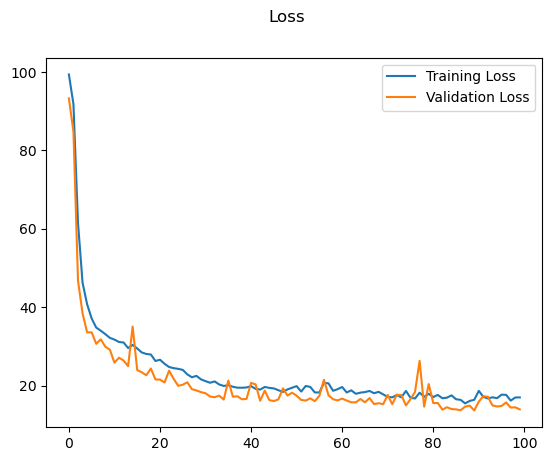

In [33]:
fig, ax = plt.subplots()
plt.plot(air_training_record.history["loss"], label="Training Loss")
plt.plot(air_training_record.history["val_loss"], label="Validation Loss")
plt.legend()
fig.suptitle("Loss")
plt.show()

In [34]:
air_pred = gpu_air_model.predict(X_test_ex)
air_pred

711/711 [==============================] - 3s 3ms/step


array([[25.546644],
       [29.761812],
       [18.50464 ],
       ...,
       [28.05536 ],
       [11.567489],
       [28.61377 ]], dtype=float32)

In [35]:
# MSLE
mean_absolute_error(y_test,air_pred)

2.615103

In [36]:
air_bn_prediction = pd.DataFrame(data=air_pred,index=air_index,columns=['AIR_TEMPERATURE'])
air_bn_prediction

,AIR_TEMPERATURE
159643,25.546644
172286,29.761812
84933,18.504641
362844,17.253052
216322,20.468185
...,...
136398,27.919235
49818,24.655596
113535,28.055361
320003,11.567489


### 모델 저장
https://velog.io/@yuns_u/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-%EB%AA%A8%EB%8D%B8-%EC%A0%80%EC%9E%A5%ED%95%98%EA%B8%B0%ED%99%95%EC%9E%A5%EC%9E%90-%EC%B6%94%EA%B0%80-%EA%B3%B5%EB%B6%80-%ED%95%84%EC%9A%94

In [37]:
import joblib

In [38]:
joblib.dump(wind_model, '../model/wind_model.pkl')
joblib.dump(gpu_air_model, '../model/air_model.pkl')

['../model/air_model.pkl']